# Examples for the QuanFin Library
## Author: Gustavo Amarante

I built this library during my studies for the CQF. I know I am not the first one to program these functionalities, but doing so helped me truly understand them.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
# Option Pricing

## Binomial Tree

In [2]:
from quantfin.options import BinomalTree

The `BinomialTree` class can price american/european calls/puts.

As a first example here is the price of an american put option on a stock.

In [3]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=4,
                 call=False,
                 option_type='american')

bt.price

2.7452952388441347

If we change the option type to european, we are not allowed to exercise the option before maturity, restricting the possibilities of making a profit. So an european put should be cheaper than an american put.

In [4]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=4,
                 call=False,
                 option_type='european')

bt.price

2.6389737155978104

The model assumes that the underlying stock price evolves through a binomial tree. You can use the `chart_stock` method to see the trajectories of this tree. The example below uses 3 steps.

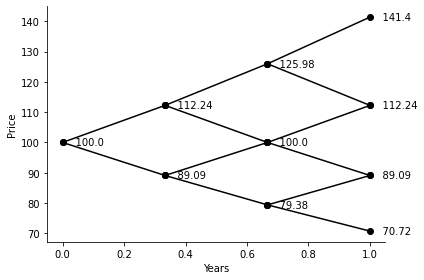

In [5]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=3,
                 call=False,
                 option_type='european')

fig = bt.chart_stock(labels=True)
plt.show()

We can also build a tree with more steps and hide the labels.

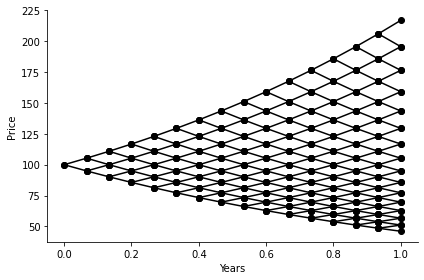

In [6]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=15,
                 call=False,
                 option_type='european')

fig = bt.chart_stock(labels=False)
plt.show()

As we have learned, as the number of steps/subdivision of the binomial tree increases, the price of the Binomial model converges to the Black-Scholes-Merton model. We can run the `BinomialTree` for several values of `n` and see how does the price converges.

We can see on the chart below that the convergence is not smooth.

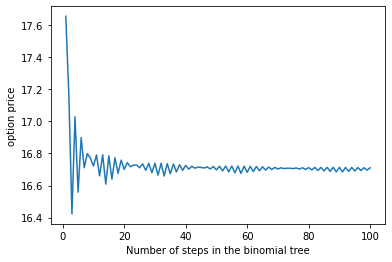

In [7]:
def option_price(n=1):
    return BinomalTree(stock=100, strike=90, years2mat=1, vol=0.20, risk_free=0.05, n=n).price


n_grid = np.arange(1, 101, 1, dtype=int)

plt.figure()
plt.plot(n_grid, list(map(option_price, n_grid)))
plt.xlabel('Number of steps in the binomial tree')
plt.ylabel('option price')
plt.show()

---
# Portfolio Construction

## Markowitz

In [8]:
from quantfin.portfolio import Markowitz

Here we are going to use an example with 3 risky assets. The cell below sets the characteristics of the risky assets.

In [9]:
# pandas series of expected returns
mu = pd.Series(data={'A': 0.10,
                     'B': 0.15,
                     'C': 0.10},
               name='mu')

# pandas series of risk
sigma = pd.Series(data={'A': 0.20,
                        'B': 0.30,
                        'C': 0.30},
                  name='sigma')

# pandas dataframe of correlations
corr = [[1.0, 0.3, 0.0],
        [0.3, 1.0, 0.0],
        [0.0, 0.0, 1.0]]

corr = pd.DataFrame(columns=['A', 'B', 'C'],
                    index=['A', 'B', 'C'],
                    data=corr)

Now we also choose the risk-free rate and the investor's risk aversion.

In [10]:
mkw = Markowitz(mu, sigma, corr,
                rf=0.05,
                risk_aversion=4)

We can grab the solutions on the attributes of `mkw`.

In [11]:
mkw.risky_weights

A    0.354355
B    0.406802
C    0.238843
Name: Risky Weights, dtype: float64

In [12]:
mkw.complete_weights

A            0.206062
B            0.236560
C            0.138890
Risk Free    0.418489
Name: Risky Weights, dtype: float64

We can also plot the results on the tradition risk-return plane.

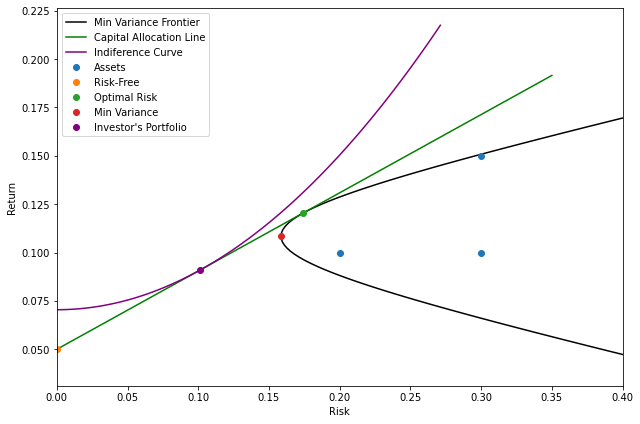

In [13]:
mkw.plot(figsize=(9, 6))

---
# Simulation

## Diffusion Processes
This classes is used to simulate and compute characteristics of classic diffusion processes of the finance literature. For now, the supported processes are:
* Simple Brownian Motion (`bm`)
* Random Walk with Drift (`rwwd`)
* Geometric Brownian Motion / Log-Normal Random Walk / Price Process (`gbm`)
* Ornstein-Uhlenbeck / Mean-Reverting Process (`ou`)

Beyond simulating this processes, the class also computes the theoretical mean and standard deviation, and computes the confidence intervals based on the theoretical distribution of the processes.

In [14]:
from quantfin.simulation import Diffusion

### Simple Brownian Motion
$$
dW_{t}
$$

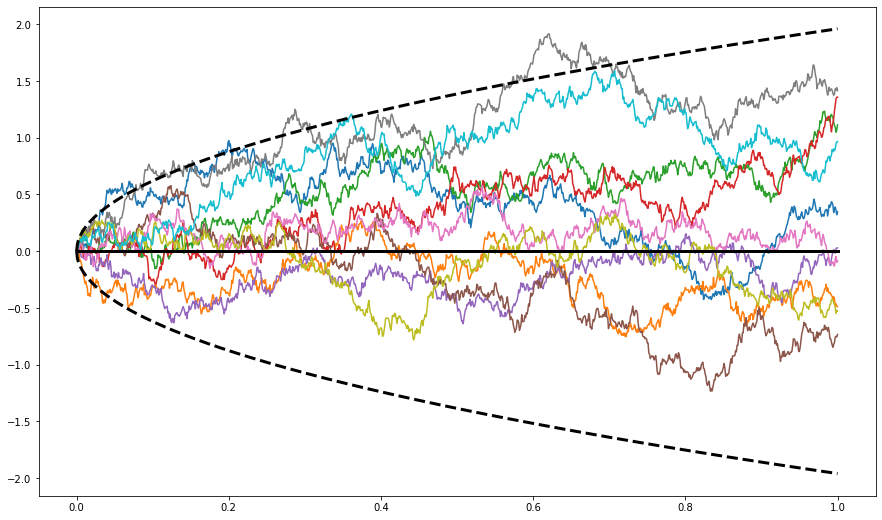

In [15]:
diff = Diffusion(T=1,  # 1-year horizon
                 n=1000,  # 1000 observation (discretization of the continous process)
                 k=10)  # simulate 10 trajectories

diff.brownian_motion.plot(legend=None, figsize=(15, 9))
diff.theoretical_mean.plot(legend=None, color='black', linewidth=3)
diff.ci_lower.plot(legend=None, color='black', linewidth=3, linestyle='--')
diff.ci_upper.plot(legend=None, color='black', linewidth=3, linestyle='--')
plt.show()

### Random Walk with Drift
$$
dS_{t}=\mu dt+\sigma dW_{t}
$$

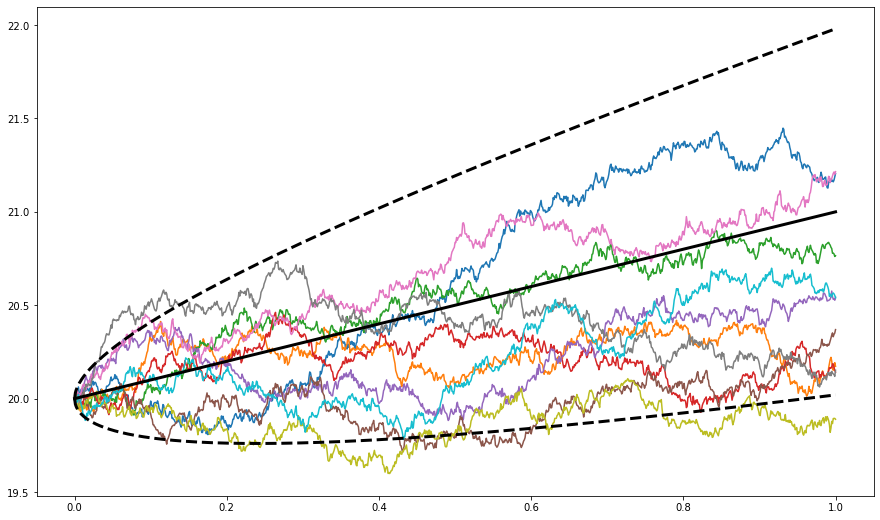

In [16]:
diff = Diffusion(T=1, 
                 n=1000, 
                 k=10, 
                 initial_price=20,  # set the initial price 
                 process_type='rwwd',  # set the process type 
                 drift=1,
                 diffusion=0.5)

diff.simulated_trajectories.plot(legend=None, figsize=(15, 9))
diff.theoretical_mean.plot(legend=None, color='black', linewidth=3)
diff.ci_lower.plot(legend=None, color='black', linewidth=3, linestyle='--')
diff.ci_upper.plot(legend=None, color='black', linewidth=3, linestyle='--')
plt.show()

### Geometric Brownian Motion
$$
dS_{t}=\mu S_{t}dt+\sigma S_{t}dW_{t}
$$

Notice that the geometric brownian motion has a log-normal distribution, which is assymetric. So we cannot calculate confidence interevals by adding and subtracting standard deviations from the mean, we need to take into account the quantiles of the distribution. So notice that the confidence interval, in this case, are assymetric as well.

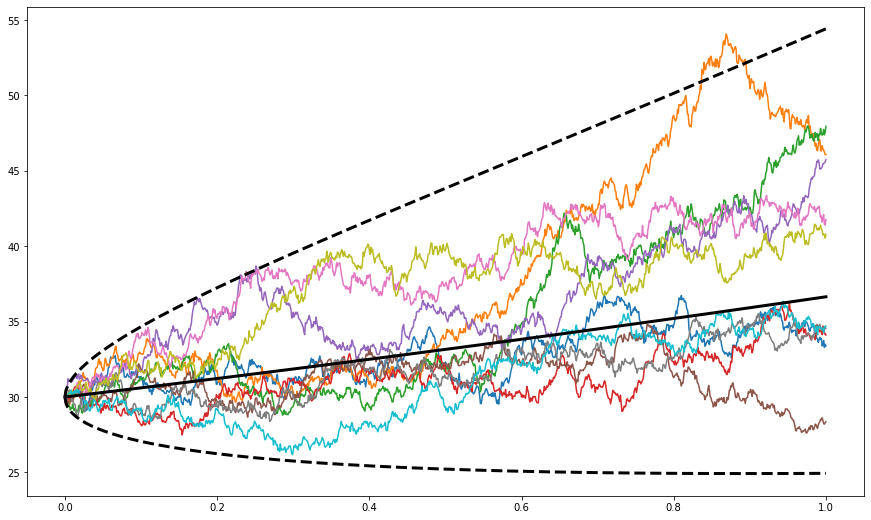

In [17]:
diff = Diffusion(T=1, n=1000, k=10, initial_price=30, process_type='gbm', drift=0.2, diffusion=0.2)

diff.simulated_trajectories.plot(legend=None, figsize=(15, 9))
diff.theoretical_mean.plot(legend=None, color='black', linewidth=3)
diff.ci_lower.plot(legend=None, color='black', linewidth=3, linestyle='--')
diff.ci_upper.plot(legend=None, color='black', linewidth=3, linestyle='--')
plt.show()

### Mean Reversion Process
$$
dS_{t}=\theta\left(\mu-S_{t}\right)dt+\sigma dW_{t}
$$

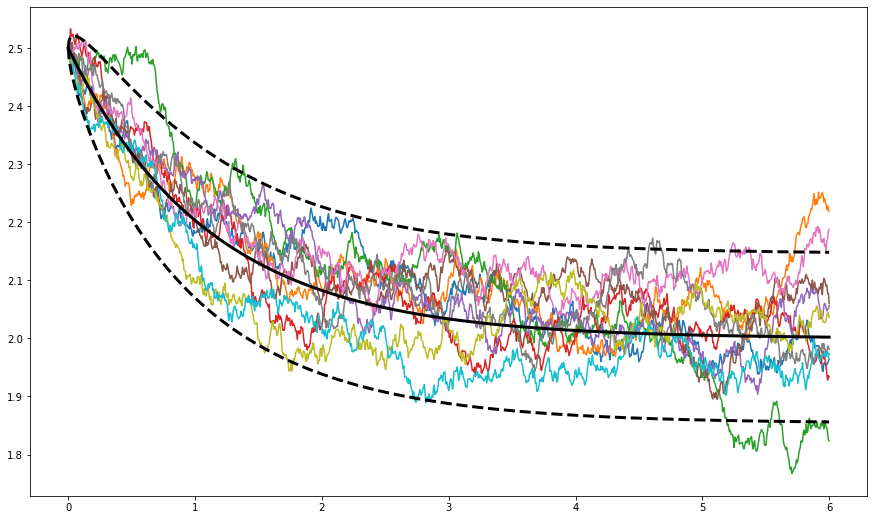

In [18]:
diff = Diffusion(T=6,   # lets look at a longer period to see the conversion
                 n=1000, 
                 k=10, 
                 initial_price=2.5,  # Start the process far from the mean
                 process_type='ou', 
                 drift=0.9,          # for the 'ou' process, 'drift' is the 'theta' parameter...
                 mean=2,             # ... and 'mean' represents the 'mu'.
                 diffusion=0.1)


diff.simulated_trajectories.plot(legend=None, figsize=(15, 9))
diff.theoretical_mean.plot(legend=None, color='black', linewidth=3)
diff.ci_lower.plot(legend=None, color='black', linewidth=3, linestyle='--')
diff.ci_upper.plot(legend=None, color='black', linewidth=3, linestyle='--')
plt.show()